# Вычислительная математика
## 2.1 Байесовское оценивание. Регуляризация. Численное решение регрессии

Содержание семинара:

- __Критерии переобучения__
- __Регуляризация наивно__
    - Ridge (l2)
    - Lasso (l1)
    - ElasticNet
- __Теорема Байеса__
    - Уточнение параметров распределений
    - Примеры применения
- __Регуляризация из теоремы Байеса__
- __Градиентный спуск - численный способ минимизации Loss-a. Простейший случай__
    - Общий алгоритм
    - Стохастический градиентный спуск
- __Гиперпараметры и кросс-валидация__
     - Grid search
     - Random search
- __Домашнее задание__

## Критерии переобучения

(Здесь и далее перезапускайте ячейку перед взаимодействием с графиками. Используются одинаковые глобальные переменные)

Вспомним основную проблему - переобучение. Характерный пример:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, widgets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Generate random data with some noise
np.random.seed(42)
x = np.linspace(0, 1, 100)
y = np.exp(-0.5*x)*np.sin(5*x) + 0.03*np.random.normal(0, 1, 100)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Define a range of model complexities (degrees of polynomial)
degrees = np.arange(1, 100)
train_loss = []
test_loss = []

for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
    X_test_poly = poly.transform(x_test.reshape(-1, 1))
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Calculate training and test loss
    train_loss.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_loss.append(mean_squared_error(y_test, model.predict(X_test_poly)))

# Function to plot based on chosen degree
def plot_polynomial(degree):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='blue', label='Original data with noise')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x_train.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_poly, y_train)
    
    x_plot = np.linspace(0, 1, 500).reshape(-1, 1)
    X_poly_plot = poly.fit_transform(x_plot)
    y_pred = model.predict(X_poly_plot)
    plt.plot(x_plot, y_pred, label=f'Degree {degree}', lw = 4, color = 'r')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.ylim((-2.5, 3))
    plt.legend(loc = 1)

    inset_ax = inset_axes(plt.subplot(1, 2, 1), width="30%", height="30%", loc=3)
    inset_ax.bar(np.arange(degree+1), np.abs(model.coef_), color = '#32CD32')
    inset_ax.set_yscale('log')
    inset_ax.set_title('Weights')
    inset_ax.tick_params(axis='x', which='both', top=True, direction = 'in', pad = -15)
    inset_ax.tick_params(axis='y', which='both', right=True, direction = 'in', pad = -25)

    plt.subplot(1, 2, 2)
    plt.semilogy(degrees, train_loss, label='Train Loss')
    plt.semilogy(degrees, test_loss, label='Test Loss')
    plt.scatter(degrees[degree - 1], test_loss[degree - 1], c = 'r',
                label='Current Loss', s=75, zorder=3)
    plt.xlabel('Model Complexity (Degree)')
    plt.ylabel('Mean Squared Error')
    plt.legend()


    plt.show()

# Create the slider
interact(plot_polynomial, degree=widgets.IntSlider(min=1, max=98, step=1, value=5))


interactive(children=(IntSlider(value=5, description='degree', max=98, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_polynomial(degree)>

Видим характерные признаки переобучения:

1. __Потеря предсказательной способности__ на тестовой выборке - а зачем нам такая модель?
2. __"Взрыв" весов__ - при большой сложности модели $m$ почти все веса становятся примерно одинаковыми и очень большими

Возникает идея, что корень проблемы лежит именно в странном поведении весов модели при увеличении её сложности. Действительно, кажется __маловероятным__, что в какой-либо задаче регрессии мы будем получать коэффициенты порядка $10^{12}$ и больше. Значит, логично давать модели __штраф за "сложность"__ (величину коэффициентов).

На этом и основан метод борьбы с переобучением - __регуляризация__.

## Регуляризация наивно

Наивно, эвристически, бороться с переобучением можно удаляя этот симптом больших весов (сложности модели). Иными словами, добавим в функцию ошибок слагаемое, отвечающие штрафу за такие скачки.

$$
\mathcal{L} \rightarrow \mathcal{L}+R(\mathbf w)
$$

Такой штраф должен ограничивать количество признаков (чтобы их не стало больше количества точек в train-е) или рост весов модели $\mathbf w$ (чтобы функция не могла быстро осциллировать).

- __L2-регуляризация__

Таким образом, самой простой функцией регуляризации является просто квадрат нормы вектора весов модели $w$, также называемая __L2-регуляризация__ (__ridge__).

$$
R(\mathbf w)=\tau\|\mathbf w\|^2=\tau \cdot \mathbf w^{T} \mathbf w, \quad \tau > 0
$$

Здесь параметр $\tau$ отвечает "силе" регуляризации. Чем он больше, теми сильнее мы "штрафуем" модель за большие признаки.

Таким образом, модифицированный MSE, например, будет выглядеть как

$$
\mathcal{L}=\frac{1}{N}\|X w-Y\|^2+\tau\|w\|^2
$$

Отметим, что в данном случае мы опять можем решить задачу аналитически, т.к. выбранная функция регуляризации дифференциируема.

$$
\frac{\partial \mathcal{L}}{\partial w}=2 X^{T}(X w-Y)+2 \tau w=0
$$

$$
2\left(X^{T} X+\tau \cdot \mathbb{1}\right) w=2 X^{T} Y
$$

$$
w_{best}=\left(X^{T} X+\tau \cdot \mathbb{1}\right)^{-1} X^{T} Y
$$

Видим, что при росте $\tau$ в обращаемой матрице растёт диагональ, что приводит к изменению её числа обусловленности. Как мы помним, число обусловленности напрямую влияет на эффективность и погрешность любых численных методов и чем оно меньше, тем лучше.

$$
\mu(X^TX)=\sqrt{\frac{\lambda_{\text {max }}}{\lambda_{\text {min }}}} \rightarrow \sqrt{\frac{\lambda_{\text {max }}+\tau}{\lambda_{\text {min }}+\tau}}
$$

Таким образом, чем меньше это выражениe, тем проще и точнее происходит обращение матрицы. Тем не менее, наша основная цель не эффективность обращения матрицы, а хорошая модель! Это значит, что параметр $\tau$ надо выбирать не из условия минимизации числа обусловленности, а из условия минимизации Loss-a.

Говорят, что $\tau$ - __гиперпараметр__ (внешний параметр), т.к. он не изменяется при обучении модели (процесса нахождения наилучшего $\mathbf w$). Они напрямую влияют на качество обучения и итоговую модель. Как подбирать наилучшие значения гиперпараметров обсудим в конце семинара.

- __L1-регуляризация__

Иным выбором функции регуляризации может служить __L1-регуляризация__ (__lasso__). Вместо квадрата модуля, мы возьмём модуль вектора непосредственно.

$$
R(\mathbf w)=\mu\|\mathbf w\|_1=\mu \sum_{\alpha=1}^m\left|\text w_\alpha\right|, \quad \mu > 0
$$

Таким образом, новая функция ошибок будет выглядеть как

$$
\mathcal{L}=\frac{1}{N}\left\|X\mathbf w-Y\right\|^2+\mu \sum_\alpha\left|\text w_\alpha\right|
$$

Отметим, что при данной регуляризации, функция ошибок недиффиренциируема в нуле и аналитическое решение получить можно, но крайне сложно и никто так не делает. Необходимо численно её минимизировать - как это делать обсудим позже в этом семинаре.

Тем не менее, данная регуляризация имеет существенное преимущество - вес признака $w_k$ может в определённый момент обнулиться, что отвечает неважности этого признака для модели. Т.е. данная регуляризация приводит к __отбору признаков__. Это позволяет избавляться от линейно-зависимых или бессмысленных признаков.

Чем больше гиперпараметр $mu$, тем больше признаков будет зануляться. При этом по мере роста $mu$ самые неинформативные признаки будут зануляться первыми. Этой процедурой можно отбирать самые важные признаки (коэффициенты модели).

-  __ElasticNet__

Иногда применяют комбинированный способ - сумма ridge и lasso. Такой регуляризатор называется __ElasticNet__. В среднем работает лучше.

$$
\mathcal{L} \rightarrow \mathcal{L}+\tau\|\mathbf w\|^2+\mu \sum_\alpha\left|\text w_\alpha\right|
$$

Есть и другие регуляризации (см. документацию sklearn и лекцию).

- __Важность нормировки__

Отдельно отметим важность нормировки данных. Во всех приведённых регуляризаторах веса признаков одинаковы ($\tau$ и $\mu$) - таким образом нам важно нормировать входные данные для модели (и иксы, и игреки) - т.е. вычитать среднее и масштабировать к единичной дисперсии, чтобы регуляризатор "одинаково относился" ко всем признакам. Естественно при таком раскладе, мы как бы "шифруем" данные для модели и при получении предсказаний их надо обратно "дешифровать".

$$
x_i^{\prime}=\left(x_i-\bar{x}\right) / \sigma_x
$$

In [2]:
# L2-регуляризация (Ridge)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, widgets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Generate random data with some noise
np.random.seed(42)
x = np.linspace(0, 2*np.pi, 100)
y = 5*np.exp(-0.5*x)*np.sin(x) + 0.05*np.random.normal(0, 1, 100)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Function to plot based on chosen degree
def plot_polynomial(degree, tau, use_scaling):
    
    # Define a range of model complexities (degrees of polynomial)
    degrees = np.arange(1, 100)
    train_loss = []
    test_loss = []

    for d in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=d)
        X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
        X_test_poly = poly.transform(x_test.reshape(-1, 1))

        # Apply standard scaling if selected
        if use_scaling:
            scaler = StandardScaler()
            X_train_poly = scaler.fit_transform(X_train_poly)
            X_test_poly = scaler.transform(X_test_poly)

        # Fit a linear regression model
        model = Ridge(tau, fit_intercept=True, solver='lsqr')
        model.fit(X_train_poly, y_train)

        # Calculate training and test loss
        train_loss.append(mean_squared_error(y_train, model.predict(X_train_poly)))
        test_loss.append(mean_squared_error(y_test, model.predict(X_test_poly)))

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='blue', label='Original data with noise')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x_train.reshape(-1, 1))
    
    # Apply standard scaling if selected
    if use_scaling:
        scaler = StandardScaler()
        X_poly = scaler.fit_transform(X_poly)

    model = Ridge(tau, fit_intercept=True, solver='lsqr')
    model.fit(X_poly, y_train)
    
    x_plot = np.linspace(0, 2*np.pi, 200).reshape(-1, 1)
    X_poly_plot = poly.transform(x_plot)
    
    # Apply standard scaling if selected
    if use_scaling:
        X_poly_plot = scaler.transform(X_poly_plot)
    
    y_pred = model.predict(X_poly_plot)
    plt.plot(x_plot, y_pred, label=f'Degree {degree}', lw = 4, color = 'r')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.ylim((-2.5, 3))
    plt.legend(loc = 1)

    inset_ax = inset_axes(plt.subplot(1, 2, 1), width="30%", height="30%", loc=3)
    inset_ax.bar(np.arange(degree+1), np.abs(model.coef_), color = '#32CD32')
    inset_ax.set_yscale('log')
    inset_ax.set_title('Weights')
    inset_ax.tick_params(axis='x', which='both', top=True, direction = 'in', pad = -15)
    inset_ax.tick_params(axis='y', which='both', right=True, direction = 'in', pad = -25)

    plt.subplot(1, 2, 2)
    plt.semilogy(degrees, train_loss, label='Train Loss')
    plt.semilogy(degrees, test_loss, label='Test Loss')
    plt.scatter(degrees[degree - 1], test_loss[degree - 1], c = 'r',
                label='Current Loss', s=75, zorder=3)
    plt.xlabel('Model Complexity (Degree)')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    plt.show()

# Create the slider
interact(plot_polynomial, 
         degree=widgets.IntSlider(min=1, max=98, step=1, value=48), 
         tau = widgets.FloatSlider(min=0.001, max=1.0, step=0.001, value=0.001, readout_format = '.3f'),
         use_scaling=widgets.Checkbox(value=True, description='Use Standard Scaling'))


interactive(children=(IntSlider(value=48, description='degree', max=98, min=1), FloatSlider(value=0.001, descr…

<function __main__.plot_polynomial(degree, tau, use_scaling)>

Видим, что теперь веса модели не взрываются + смогли получить хорошую аппроксимацию даже при большом $m$!

Отдельно отметим крайне большую важность нормировки данных.

Попробуем другую регуляризацию.

In [3]:
# L1-регуляризация (Lasso)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, widgets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Generate random data with some noise
np.random.seed(42)
x = np.linspace(0, 2*np.pi, 100)
y = 5*np.exp(-0.5*x)*np.sin(x) + 0.05*np.random.normal(0, 1, 100)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Function to plot based on chosen degree
def plot_polynomial(degree, mu, use_scaling):
    
    # Define a range of model complexities (degrees of polynomial)
    degrees = np.arange(1, 100)
    train_loss = []
    test_loss = []

    for d in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=d)
        X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
        X_test_poly = poly.transform(x_test.reshape(-1, 1))

        # Apply standard scaling if selected
        if use_scaling:
            scaler = StandardScaler()
            X_train_poly = scaler.fit_transform(X_train_poly)
            X_test_poly = scaler.transform(X_test_poly)

        # Fit a linear regression model
        model = Lasso(mu, fit_intercept=True, max_iter=10000, tol = 0.5*1e-2, warm_start=True)
        model.fit(X_train_poly, y_train)

        # Calculate training and test loss
        train_loss.append(mean_squared_error(y_train, model.predict(X_train_poly)))
        test_loss.append(mean_squared_error(y_test, model.predict(X_test_poly)))

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='blue', label='Original data with noise')
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x_train.reshape(-1, 1))
    
    # Apply standard scaling if selected
    if use_scaling:
        scaler = StandardScaler()
        X_poly = scaler.fit_transform(X_poly)
    
    model = Lasso(mu, fit_intercept=True, max_iter=10000, tol = 0.5*1e-2, warm_start=True)
    model.fit(X_poly, y_train)
    
    x_plot = np.linspace(0, 2*np.pi, 200).reshape(-1, 1)
    X_poly_plot = poly.transform(x_plot)
    
    # Apply standard scaling if selected
    if use_scaling:
        X_poly_plot = scaler.transform(X_poly_plot)
    
    y_pred = model.predict(X_poly_plot)
    plt.plot(x_plot, y_pred, label=f'Degree {degree}', lw=4, color='r')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.ylim((-2.5, 3))
    plt.legend(loc=1)

    inset_ax = inset_axes(plt.subplot(1, 2, 1), width="30%", height="30%", loc=3)
    inset_ax.bar(np.arange(degree+1), np.abs(model.coef_), color='#32CD32')
    inset_ax.set_yscale('log')
    inset_ax.set_title('Weights')
    inset_ax.tick_params(axis='x', which='both', top=True, direction='in', pad=-15)
    inset_ax.tick_params(axis='y', which='both', right=True, direction='in', pad=-25)

    plt.subplot(1, 2, 2)
    plt.semilogy(degrees, train_loss, label='Train Loss')
    plt.semilogy(degrees, test_loss, label='Test Loss')
    plt.scatter(degrees[degree - 1], test_loss[degree - 1], c='r',
                label='Current Loss', s=75, zorder=3)
    plt.xlabel('Model Complexity (Degree)')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    plt.show()

# Create the slider
interact(plot_polynomial, 
         degree=widgets.IntSlider(min=1, max=98, step=1, value=90), 
         mu=widgets.FloatSlider(min=0.001, max=0.1, step=0.001,
                                value=0.001, readout_format='.4f'),
         use_scaling=widgets.Checkbox(value=True, description='Use Standard Scaling'))


interactive(children=(IntSlider(value=90, description='degree', max=98, min=1), FloatSlider(value=0.001, descr…

<function __main__.plot_polynomial(degree, mu, use_scaling)>

Видим, что также смогли получить относительно хорошую аппроксимацию при большой сложности модели.

Заметим, что теперь почти все признаки занулились! Более того, чем больше параметр $\mu$, тем больше параметров зануляется. Так можно выявлять наиболее важные параметры в задаче регрессии.

Таким образом, регуляризация позволяет обучать сложные модели (что критично в тех случаях, когда простой моделью хорошего результата получить не удалось).

## Теорема Байеса

Основная идея теоремы Байеса - __уточнение вероятности гипотезы при учёте новых данных__.

__Формула Байеса__:

>$$
P(A \mid B)=\frac{P(B \mid A) \cdot P(A)}{P(B)}
$$
>
>где
>
>- $P(A)$ - __априорная вероятность__ гипотезы $A$ (до получения данных о истинности события $B$);
>
>- $P(A \mid B)$ - вероятность гипотезы $A$ при наступлении события $B$ (уточнённая, __апостериорная вероятность__);
>
>- $P(B \mid A)$ - вероятность наступления события $B$ при истинности гипотезы $A$ (__правдоподобие, likelihood__;
>
>- $P(B)$ - полная вероятность наступления события $B$.

Последнее в простом случае можно считать через __формулу полной вероятности__:

>$$
P(B) =P(B \mid A) \cdot P(A) + P(B \mid \bar{A}) \cdot P(\bar{A})
$$
>
>где $\bar{A}$ - означает событие ложности гипотезы $A$.

__Примечание.__ В более общем случае можно обобщить формулу Байеса на $n$ непересекающихся гипотез $A_i$, имеющих суммарную вероятность 1:

$$
P\left(A_j \mid B\right)=\frac{P\left(B \mid A_j\right) P\left(A_j\right)}{\sum_{i=1}^n P\left(B \mid A_i\right) P\left(A_i\right)}
$$

или, что то же самое:

$$
P\left(A_j \mid B\right)=\frac{P\left(B \cap A_j\right)}{\sum_{k=1}^n P\left(B \cap A_k\right)}
$$

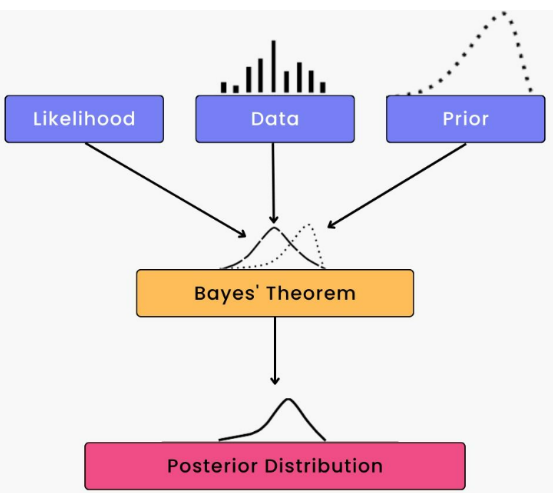

### Пример с короновирусом

Ультрачувствительный тест от короновируса ошибается в 1\% случаев (как в одну, так и в другую сторону). В данный момент в популяциии доля заболевших $10^{-5}$. Петя получил положительный тест на коронавирус.

С какой вероятностью он действительно болеет коронавирусом?

__Решение:__

Обозначим за $A$ событие болезни короновирусом (__гипотезу__), через $B$ - положительный результат теста (__новые данные__). 

Тогда до новых данных вероятность Пете заболеть (__априорная вероятность__) была:

$$
P(A) = 10^{-5}
$$

Хотим уточнить эту вероятность с учётом новых данных (события $B$), для которых верно:

$$ 
P(B \mid A)=0.99, \quad P(B \mid \bar{A})=0.01
$$

По формуле Байеса для уточнённой вероятности:

$$ \\
\begin{gathered}
P(A \mid B)=\frac{P(B \mid A) P(A)}{P(B)}=\frac{P(B \mid A) P(A)}{P(B \mid A) P(A)+P(B \mid \bar{A}) P(\bar{A})} \\   \\  
P(A \mid B)=\frac{0.99 \cdot 10^{-5}}{0.99 \cdot 10^{-5}+0.01 \cdot\left(1-10^{-5}\right)}=9.89 \cdot 10^{-4} \approx 10^{-3}
\end{gathered} \\
$$

Видим, что вероятность быть больным после учёта теста (__апостериорная вероятность__) возросла! Но не очень-то и сильно, т.к. в целом больных короновирусом много меньше всех остальных, что и учитывает формула Байеса. 

Возможно, Пете стоит сделать пройти тест ещё раз.

### Уточнение параметров распределений

Пусть имеем некоторое распределение, зависящее от некоторых параметров $λ$. Например:

- дискретное распределение Пуассона $p_λ(k) \equiv \mathbb{P}(Y=k) =\, \frac{λ^k}{k !} e^{-λ} = P(k \mid \lambda)$
- непрерывное распределение Гаусса $p_λ(x)=\frac{1}{λ_1 \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-λ_2}{λ_1}\right)^2} = p(x \mid \lambda)$

На практике мы __не знаем__ параметры $λ$ этого распределения. Их нужно как-то определить. Теорема Байеса даёт один из возможных подходов исходя из разной вероятности иметь текущие $λ$ для данного распределния. Иными словами, у нас есть __ещё одно распределение на параметры $λ$__, которое мы и хотим получить.

Схема такая:

>1. Имеем $P(λ)$ - априорное распределение значения параметр(а/ов) распределения
>2. Получаем экспериментальную точку $m$
>3. Из теоремы Байеса получаем уточнённое (апостериорное) распределение параметров при новых данных $P(λ \mid m)$.
>4. Принимаем уточненное распределение за априорное и повторяем п. 1 - 3 пока не ~надоест~ сойдёмся.

Наивно, стартовать можно с любого априорного распределения, но доказывать сиё утверждение мы, конечно, не будем.

А как считать $P(λ|m)$ - апостериорное распределение на параметры при учёте получения данных $m$? Просто записываем теорему Байеса в следующем виде:

>$$ 
P(λ \mid m)=\frac{P(m \mid λ) \cdot P(λ)}{P(m)}=\frac{P(m \mid λ) \cdot P(λ)}{\int d λ \cdot P(m \mid λ) \cdot P(λ)} = \frac{p_λ(m) \cdot P(λ)}{\int d λ \cdot p_λ(m) \cdot P(λ)}
$$

Как видим, отличие в основном в том, что в формуле полной вероятности сумму заменил интеграл по распределению.

Таким образом, __апостериорное распределение на иксы__ после учёта __ВСЕХ__ новых данных:

>$$
\tilde{p} (x) = \int d \lambda \cdot P ( x \mid \lambda) \cdot P ( \lambda \mid m_1, m_2, \cdots )
$$


### Пример с фальшивой монеткой

Пусть есть монетка, которая может выпадать решкой или орлом. Здесь и далее $m=0$ - выпала решка, $m=1$ - выпал орёл.

За параметр распределения $λ$ возьмём вероятность выпадения орла. Тогда распределение на возможные варианты исхода одного броска:

$$
p_\lambda(m)=\left\{\begin{array}{c}
1-\lambda, \quad m=0 \\
\lambda, \quad m=1
\end{array}\right.\\
$$

Как и выше, считаем, что есть некоторое распределение на возможные $λ$. Понятно, что для обычной монеты оно должно быть в идеале $P_\text{ideal}(\lambda) = \delta (\lambda - 0.5)$, а для шулерской что-то пойдёт не так.

Для примера, положим, что шулерская монета только в 40% случаев выпадает орлом. В качестве начального априорного распределения положим равновероятный вариант иметь честную и шулерскую монету. Математически, это можно записать как:

$$
P(\lambda) = \frac{1}{2} \cdot \delta (\lambda - 0.5) + \frac{1}{2} \cdot \delta (\lambda - 0.4)
$$

Проведём один эксперимент в котором, положим, выпал орёл $m=1$. Апостериорная вероятность с учётом новых данных:

$$
P(\lambda \mid 1)=\cfrac{p(1 \mid \lambda) \cdot P(\lambda)}{p(1)} = \cfrac{p_\lambda(1) \cdot P(\lambda)}{\int_\lambda d \lambda P(\lambda) p_\lambda(1)} = \cfrac{\frac{\lambda}{2} \cdot \delta (\lambda - 0.5) + \frac{\lambda}{2} \cdot \delta (\lambda - 0.4)}{\int_\lambda d \lambda \left(\frac{\lambda}{2} \cdot \delta (\lambda - 0.5) + \frac{\lambda}{2} \cdot \delta (\lambda - 0.4)\right) }
$$

$$
P(\lambda \mid 1)= \cfrac{\frac{0.5}{2} \cdot \delta (\lambda - 0.5) + \frac{0.4}{2} \cdot \delta (\lambda - 0.4)}{0.5 \cdot 0.4+0.5 \cdot 0.5}
$$

$$
P(\lambda \mid 1)= \frac{5}{9} \cdot \delta (\lambda - 0.5) + \frac{4}{9} \cdot \delta (\lambda - 0.4)
$$

Аналогично, можно считать и далее. Например, пусть второй раз выпала решка $m=0$. Пользуемся теми же самыми формулами, приняв последнее выражение за новую априорную вероятность $P(\lambda)\stackrel{\text{redefine}}{=}P(\lambda \mid 1)$. 

Итого,

$$
P(\lambda \mid 1, 0)= \frac{25}{41} \cdot \delta (\lambda - 0.5) + \frac{16}{41} \cdot \delta (\lambda - 0.4)
$$

И т.д. Т.е. для конкретного набора результатов бросков мы всегда можем оценить вероятность, была ли использована шулерская монета. 

Алгоритм, работающий аналогичным образом для решения задач классификации, называется __наивным байесовским классификатором__. Чтобы определить вероятность истинности гипотезы о принадлежности объекта к тому или иному классу, наивный байесовский классификатор аналогичным образом использует информацию по каждому признаку. Результаты выпадения монетки в данном случае аналогичны проявлению класса объекта в виде того или иного признака.

## Регуляризация из теоремы Байеса

Модели зависимости переменных также бывают вероятностные - это иной подход к решению задачи регрессии, основанный не на минимизации функции потерь, а на максимизации вероятностного правдоподобия модели.

В этом рассмотрении мы сможем дать вероятностное объяснение корректности решения задачи регрессии с использованием регуляризации. Это позволит также оценить случайную погрешность весов модели.

__Гауссова вероятностная модель (напоминание)__

Пусть нам дан набор точек $\left\{\left(x_i, y_i\right)\right\}_{i=1}^N$ и пусть их систематическая (приборная) погрешность равна нулю. Опять-таки надо найти наилучшую аппроксимирующую модель.

Как и раньше, будем решать эту задачу линейной регрессией. Пусть также наша модель отличается от истинных $y_i$ на некоторый шум

$$
y_i=X_{i \alpha} w_\alpha+\epsilon_i, \quad \epsilon_i \sim  \mathcal{N}\left(0, \sigma^2\right)
$$

Здесь $\epsilon_i$ - это случайный гауссов шум, объясняющий, почему исходные точки не лежат точно на нашей модели. Отметим, что $\sigma$ нам неизвестна, но одинакова для всех точек выборки.

 __Принцип максимизации правдоподобия (likelyhood) (напоминание)__

В отличие от эмпирически выбранной функции потерь, будем пользоваться __принципом максимизации правдоподобия (likelyhood)__. Он заключается в максимизации вероятности пронаблюдать истинные $y_i$ в нашей нашей вероятностной модели.

Иными словами, нам надо подобрать такие $w$, чтобы вероятность $P_w(y)$ нашей модели $\check{y}_i=X_{i \alpha} w_\alpha$ с учётом шума $\epsilon_i$ выдать истинные $y_i$ была максимальной. При этом выборка фиксирована. Эта вероятность называется __правдоподобием данных__.

$$P_w(y) \rightarrow \max _w$$

Т.к. вероятность независимость событий есть произведение их вероятностей, суммарная верность будет большим произведением, что не очень удобно. Поэтому переходят к эквивалентной задаче, беря логарифм от этой вероятности (это эквивалентный шаг, т.к. максимизация $\log P_w(y)$ равносильна максимизации $P_w(y)$). Для удобства, эту штуку также называют правдоподобием.

$$\log P_w(y) $$

Распишем подробнее,

$$
P_w(y)=\prod_{i=1}^l \mathcal{N}\left(0, \sigma^2\right)\left[\epsilon_i\right]=\prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{\left(y_i-X_{i \alpha} w_\alpha\right)^2}{2 \sigma^2}\right)
$$

Логарифмируем,

$$
\log P_w(y)=\sum_{i=1}^N\left\{-\frac{1}{2} \log 2 \pi \sigma^2-\frac{\left(y_i-X_{i\alpha} w_\alpha\right)^2}{2 \sigma^2}\right\} \rightarrow \max _w
$$

Заметим, что первые слагаемые от $w$ не зависят, а вторые слагаемые в этой сумме образуют сумму квадратов отклонений, т.е. они образуют функцию потерь в методе наименьших квадратов. Получается, что __МНК эквивалентен принципу максимизации правдоподобия с гауссовой вероятностной моделью__. Это и есть вероятностный смысл МНК.


__Вероятностный смысл регуляризации__

Перепишем наше правдоподобие в терминах условной вероятности. Действительно вероятность $P_w(y)$ по сути своей есть вероятность пронаблюдать $y$ при фиксированных $w$ и $x$:

$$
P_w(y)=P(y \mid w, x)
$$

Посмотрим на это со следующей точки зрения. До самого процесса максимизации правдоподобия, уже имелось некоторое распределение вероятности получить те или иные $w$ - __априорное распределение__ (до процесса измерения $w$). Действительно, вероятность получить крайне большие $w$ крайне мала для любой задачи. Обозначим это априорное распределение как $p_\gamma(w)$, где $\gamma$ - некоторые гиперпараметры.

Т.к. мы ввели функцию распределения, мы обязаны трактовать $w$ как случайные величины. Таким образом в такой трактовке мы обязаны максимизировать __правдоподобие данных и модели__. Обозначим её за $\widetilde{P}(y, w \mid x)$ и тогда,

$$
\widetilde{P}(y, w \mid x)=P(y \mid x, w) \cdot p_\gamma(w)=P_w(y) \cdot p_\gamma(w)
$$

Логарифмируя,

$$
\log \widetilde{P}(y, w \mid x)=\log P_w(y) + \log p_\gamma(w) = \text { const по }w-\frac{1}{2 \sigma^2} \mathcal{L}+\log p_\gamma(w)\rightarrow \max _w
$$

А отсюда уже видно, что выбор подходящего априорного распределения $p_\gamma(w)$ и даёт нам нужную функцию потерь! Иначе говоря, регуляризация - это лишь постулирование, что $w$ до процесса измерения имеют некоторое распределение  $p_\gamma(w)$, отвечающее выбранной регуляризации. Проиллюстрируем это.

Если взять  $p_\gamma(w)$ как гауссово распределение, мы получим L2-регуляризацию:

$$
p_\gamma\left(w_\alpha\right)=\frac{1}{\sqrt{2 \pi \gamma}} e^{-\frac{w_\alpha^2}{2 \gamma}}
$$

$$
\log p_\gamma=\text{const по $w$} -\frac{w_\alpha^2}{2 \gamma}
$$

$$
\log \widetilde{P}(y, w \mid x)= \text { const по }w-\frac{1}{2 \sigma^2} \left( \mathcal{L}-w_\alpha^2\frac{\sigma^2}{\gamma} \right)\rightarrow \max _w
$$

Откуда видим, что в прежних обозначениях $\tau = \frac{\sigma^2}{\gamma}$.

Аналогично, L1-регуляризация получается из распределения Лапласа $p_ \gamma\left(w_\alpha\right)=\frac{1}{2 \gamma} e^{-\frac{\left|w_\alpha\right|}{\gamma}}$.

Опять таки видим одинаковый масштаб для всех весов $w$ - т.е. важно нормировать данные! Иначе, мы бы сразу неявно воспринимали некоторые признаки более важными, чем другие.

## Градиентный спуск - численный способ минимизации Loss-a. Простейший случай

Напомним, что градиент функции нескольких переменных - это вектор направления наибольшего роста функции.

Как мы уже поняли, аналитически решать задачу регрессии не всегда получается эффективно, если вообще получается. Таким образом, нам надо научится численно минимизировать функцию потерь. Простейший и самый распространённый способ это сделать заключается в применении __градиентного спуска__.

Продемонстрируем на примере решении задачи линейной регрессии с MSE Loss и регуляризатором ElasticNet. Она не решается аналитически, и необходимо численно минимизировать

$$
\mathcal{L}(w)=\frac{1}{N} \sum_{i=1}^{N}\left( X_{i \alpha} w_\alpha-y_i\right)^2+\tau \sum_{i=1}^N w_i^2+\mu \sum_{i=1}^N\left|w_i\right|
$$

$$
\mathcal{L}(w) \longrightarrow \min _w
$$

Общий __алгоритм градиентного спуска__ будет следующим образом:



>0. Фиксируем малый $\varepsilon$ - условие остановки алгоритма.
>
>1. Выберем начальное приближение $w^{(0)} \in \mathbb{R}^m$. Как правило, инициализируют случайным образом.

>2. Каждую последующую точку выбираем в направлении обратном градиенту $\mathcal{L}$ - таким образом мы двигаемся в направлении минимизации $\mathcal{L}$.
>$$w^{(n+1)}_k=w^{(n)}_k-\alpha \cdot  \left.\frac{\partial \mathcal{L}(w)}{\partial w_{k}}\right|_{w^{(n)}} $$

>Здесь $\alpha$ - так называемый шаг градиентного спуска (или __learning rate__). Если он будет слишком большим, мы не упадём в минимум и будем туда-сюда скакать около него. Если он будет слишком маленьким, мы рискуем так и не дойти до минимума. Таким образом, он является подбираемым гиперпараметром.

>3. Если на каком-то шаге получилось, что

>$$|\mathcal{L}(w^{(n+1)}) - \mathcal{L}(w^{(n)})| < \varepsilon$$

>То алгоритм останавливается и последнее получившееся $w_{final}=w^{(n+1)}$  принимается за окончательный ответ. Иначе на шаг 2.



Стоит отметить, что по хорошему, надо строить зависимость $\mathcal{L}(n)$. Т.к. для произвольной функции или для данных гиперпараметров алгоритм может и не сойтись. В идеальном случае, это будет монотонно стремящаяся к нулю функция. В плохом - сильно осциллирующая краказябра.


Естественно, это самая простая реализация градиентного спуска. Её можно существенно улучшить различными приёмчиками. В частности, learning rate можно сделать зависимым от $n$. К примеру,

$$
\alpha(n) = \frac{1}{n}
$$

Если же мы попали в точку, где градиента не существует (что крайне маловероятно, т.к. их мера нуль), то можно просто взять любое небольшое направление сдвига, чтобы из неё выйти - хорошим ориентром будет градиент в близкой точке, в которой функция дифференциируема.

__Стохастический градиентный спуск__

Часто функция потерь - это сумма большого числа слагаемых. Если обучающая выборка достаточно велика, вычислять эту сумму будет проблематично и затратно - градиентный спуск будет работать крайне медленно.

Решить эту проблему помогает стохастический градиентный спуск. Его идея - вычислять градиент функции потерь на каждом шаге алгоритма не по всей выборке, а по некоторой подвыборке (__batch__), которая будет меняться каждый шаг.

Если старый градиент рассчитывался по всей выборке

$$
\nabla \mathcal{L}=\frac{1}{N} \sum_{i=1}^N\left(\nabla \mathcal{L}_i\right)
$$

то на batch-е размером $B \ll N$ градиент не должен сильно поменяться

$$
\nabla \mathcal{L} \approx \frac{1}{B} \sum_{i=1}^B\left(\nabla \mathcal{L}_i\right)
$$

Иными словами, мы "нарезаем" нашу обучающую выборку из $N$ элементов на $N/B$ кусков, на каждом из которых вычисляем градиент поочередно. Таким образом вся обучающая выборка используется, но нам нет необходимости суммировать огромное количество слагаемых для одного шага алгоритма.

Один проход по всей выборке называется __эпохой__. После окончания эпохи (прохода по всей выборке) можно опять "нарезать" выборку на $N/B$ частей случайным образом (чтобы исключить какие-либо корреляции) и повторять процесс. В таком случае, как правило, строят зависимость $\mathcal{L}$ от $k$-ой эпохи.

Понятно, что процесс будет стохастическим, и на каждом шаге алгоритма мы будем чутка отклоняться от направления на минимум. Тем не менее, этот шум даже полезен, т.к. он помогает не проваливаться в узкие локальные минимумы - эмпирический факт :).

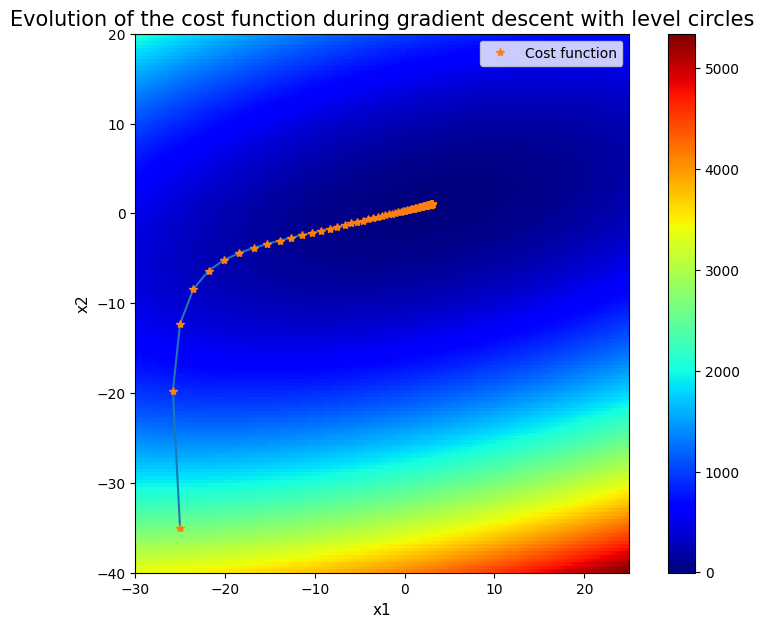

In [4]:
# Реализация градиентного спуска
# Ищем минимум следующей функции

def f(x1, x2):
    return 0.5*x1**2 + (5/2)*x2**2 - x1*x2 - 2*(x1 + x2)

def gradient(x1, x2):
    return np.array([-2 + x1 - x2, -2 - x1 + 5*x2])

def norm(matrice_1x2):
    n_line = matrice_1x2.shape[0]
    N = 0
    for i in range(n_line):
        N += matrice_1x2[i]**2
    return np.sqrt(N)

x1, x2 = -25, -35
alpha = 0.1
epsilon = pow(10,-6)

grad_f = gradient(x1, x2)
n_grad = norm(grad_f)

i = 1
evolution_X1_X2 = [[x1, x2]]
while n_grad > epsilon:

    direction = -grad_f
    x1, x2 = x1 + alpha*direction[0], x2 + alpha*direction[1]
    evolution_X1_X2 = np.vstack((evolution_X1_X2, [x1, x2]))
    grad_f = gradient(x1, x2)
    n_grad = norm(grad_f)
    i += 1

evolution_X1 = evolution_X1_X2[:, 0]
evolution_X2 = evolution_X1_X2[:, 1]


x1 = np.linspace(-30, 25, 150)
x2 = np.linspace(-40, 20, 150)
X1, X2 = np.meshgrid(x1, x2)
Z = f(X1, X2)

fig = plt.figure(figsize = (10,7))
plt.grid(False)
plt.imshow(Z, extent = [-30,25,-40,20], origin = 'lower', cmap = 'jet', alpha = 1)
plt.title("Evolution of the cost function during gradient descent with level circles", fontsize=15)
plt.plot(evolution_X1, evolution_X2)
plt.plot(evolution_X1, evolution_X2, '*', label = "Cost function")
plt.xlabel('x1', fontsize=11)
plt.ylabel('x2', fontsize=11)
plt.colorbar()
plt.legend(loc = "upper right")
plt.show()

## Гиперпараметры и кросс-валидация

Для подбора гиперпараметров необходимо минимизировать влияние конкретного выбора тестовой и обучающей выборки. Для этого можно например использовать следующий алгоритм __кросс-валидации__ K-Fold:

>1. Фиксируется некоторое целое число $k$ (обычно от 5 до 10), меньшее числа семплов в датасете.
>2. Датасет разбивается на $k$ одинаковых частей (в последней части может быть меньше семплов, чем в остальных). Эти части называются фолдами.
>3. Далее происходит $k$ итераций, во время каждой из которых один фолд выступает в роли тестового множества, а объединение остальных - в роли тренировочного. Модель учится на $k-1$ фолде и тестируется на оставшемся.
>4. Финальный скор модели получается либо усреднением $k$ получившихся тестовых результатов, либо измеряется на отложенном тестовом множестве, не участвовавшем в кросс-валидации.


![image](https://yastatic.net/s3/ml-handbook/admin/7_3_98fef6af39.png)

Подробнее тут: https://academy.yandex.ru/handbook/ml/article/kross-validaciya

Наконец, обcудим процесс подбора гиперпараметров. Тут всё просто - перебираем какое-либо количество гиперпараметров по сетке (__grid-search__) или случайным образом (__random-search__), считаем кросс-валидацией Loss на каждой точке перебора, а в конце выбираем наилучший набор гиперпараметров.

In [5]:
# Кросс-валидация гиперпараметров -

hyperparams = {'alpha': [10000, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
               'max_iter': [1000, 10000, 100000]}

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=Lasso(fit_intercept=False, warm_start=False),
                      param_grid=hyperparams,
                      cv=5,
                      verbose=1,
                      scoring='neg_mean_squared_error', # Эта функция максимизирует, берём neg
                      return_train_score=True)

In [6]:
from sklearn.metrics import get_scorer_names
#get_scorer_names()

In [7]:
# Возьмём следующий пример:
xs = np.arange(0, 1, 0.01).reshape((-1, 1))
noise = np.random.normal(0., 0.2, size = xs.shape[0]).reshape((-1, 1))
ys = np.sin(20*xs) + np.sin(10*xs) + np.sin(40*xs) + noise

def make_sin_matrix(x, max_order):
    X = np.ones(x.shape)
    for k in range(1, max_order + 1):
        X = np.concatenate([X, np.sin(k*x)], axis = 1)
    return X

gs.fit(make_sin_matrix(xs, 50), ys)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.267e-02, tolerance: 1.171e-02
  model = cd_fast.enet_coordinate_descent(
/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.683e-02, tolerance: 1.376e-02
  model = cd_fast.enet_coordinate_descent(
/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3

/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+00, tolerance: 1.171e-02
  model = cd_fast.enet_coordinate_descent(
/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.068e+00, tolerance: 1.376e-02
  model = cd_fast.enet_coordinate_descent(
/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8

/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+00, tolerance: 1.171e-02
  model = cd_fast.enet_coordinate_descent(
/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+00, tolerance: 1.376e-02
  model = cd_fast.enet_coordinate_descent(
/home/rfrelpe/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

GridSearchCV(cv=5, estimator=Lasso(fit_intercept=False),
             param_grid={'alpha': [10000, 0.1, 0.01, 0.001, 0.0001, 1e-05,
                                   1e-06, 1e-07, 1e-08, 1e-09],
                         'max_iter': [1000, 10000, 100000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
gs.best_params_

{'alpha': 0.01, 'max_iter': 1000}

In [9]:
gs.best_score_

-0.05930858768400178

In [10]:
import pandas as pd

results = pd.DataFrame(gs.cv_results_['params'])
results['test_score'] = gs.cv_results_['mean_test_score']

results

,alpha,max_iter,test_score
0,1.000000e+04,1000,-1.543034
1,1.000000e+04,10000,-1.543034
2,1.000000e+04,100000,-1.543034
3,1.000000e-01,1000,-0.316938
4,1.000000e-01,10000,-0.316938
5,1.000000e-01,100000,-0.316938
6,1.000000e-02,1000,-0.059309
7,1.000000e-02,10000,-0.059309
8,1.000000e-02,100000,-0.059309
9,1.000000e-03,1000,-0.171500
